# Isolating single channel stains with OpenCV 3.2.0
#### Created for the Basanta Lab @ Moffitt Department of Integrated Mathematical Oncology
#### By: Matthew Wicker

 In this notebook, we will go over one method for isolating a single channel stain using Python 2.7 and OpenCV 3.2.0. The goal of this notebook is not only to teach how to isolate a single channel stain, but to discuss the process of building such an algorithm. This will include trouble shooting and parameter tuning. 

### Part One: Load in your test image

In the same directory as this Jupyter Notebook, we should have a test image called 'test.png' In order to work with this image, we will first need to load it in with OpenCV as follows: 

In [1]:
# Below is the import statement for OpenCV. If you have OpenCV installed properly, 
# this should work without error
import cv2
img = cv2.imread('test.png', cv2.IMREAD_UNCHANGED)

### Part Two: Convert to RGB and Show
Now that we have made sure OpenCV is properly installed, and that we are able to load in an image, we are going to make sure that we have loaded the appropriate image. To do this, we will need matplotlib.

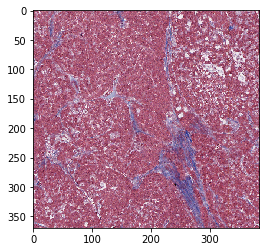

In [2]:
# This is the import for matplotlib (we will call it plt), and a line of code that makes
# it plot directly in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# We will first plot the image, and then show it using matplotlib:
plt.imshow(img)
plt.show()

### Part Three: Splitting the Image into its Channels
Now that we have loaded the image, and we are sure that we have the right image, we are going to get each of the three channels and split them apart so we can see exactly what this image is made up of. (Of course, since we are trying to isolate a single channel, we will be looking particularly at the blue channel a.k.a. the channel of interest)

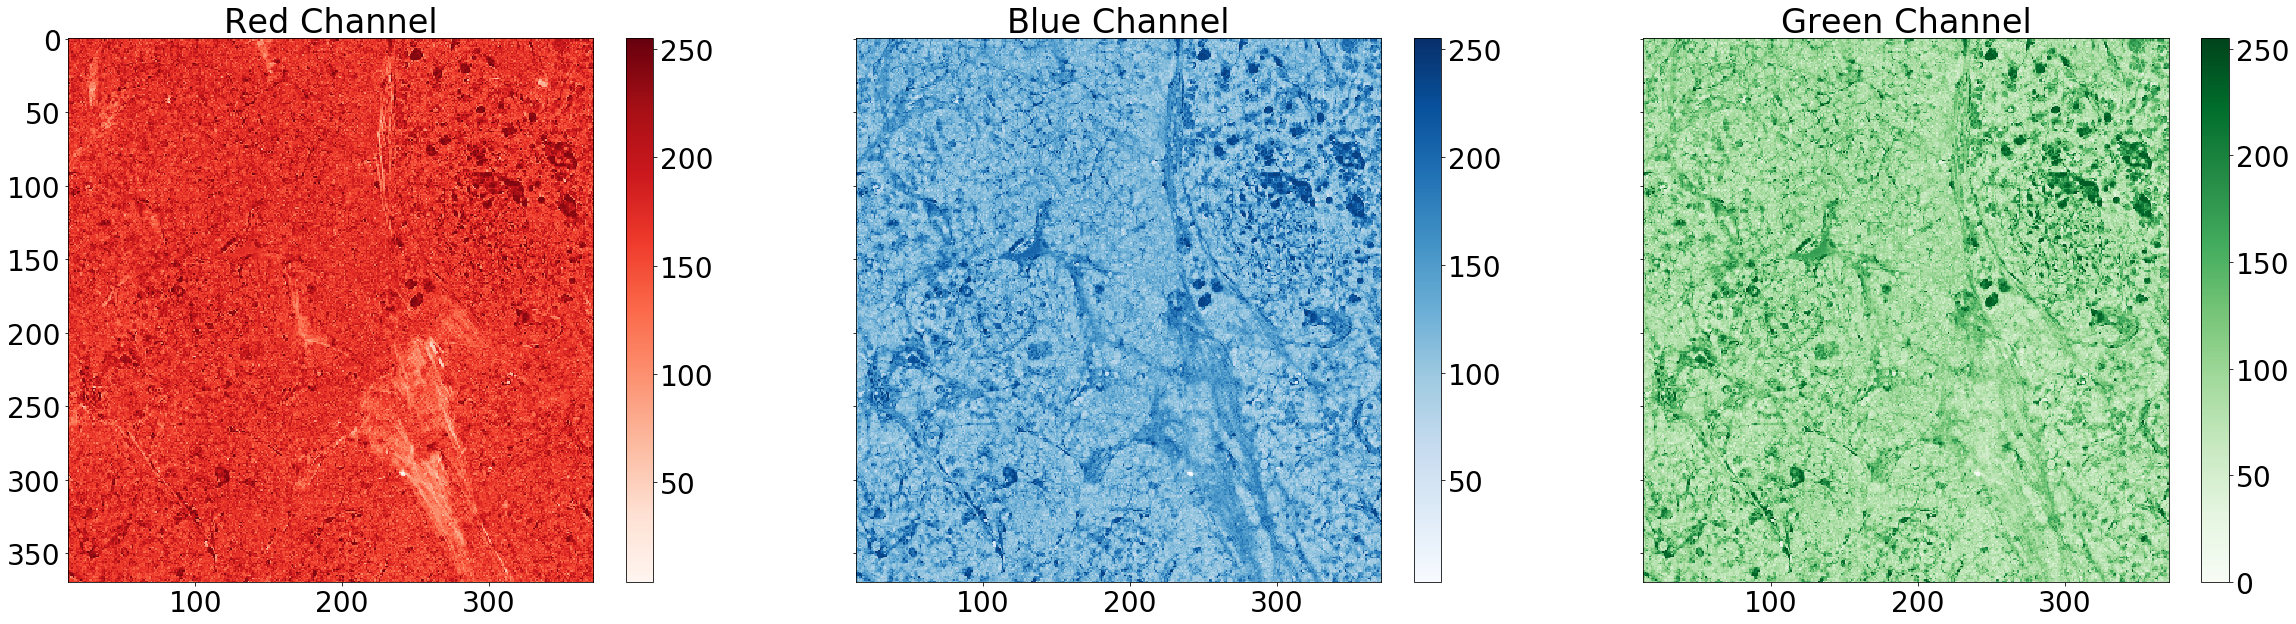

In [3]:
plt.rcParams.update({'font.size': 28})
img_r, img_g, img_b = cv2.split(img)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(40, 10))
ax1.set_title('Red Channel')
fig1 = ax1.imshow(img_r,  cmap='Reds')
plt.colorbar(fig1,ax=ax1)

ax2.set_title('Blue Channel')
fig2 = ax2.imshow(img_b,  cmap='Blues')
plt.colorbar(fig2,ax=ax2)

ax3.set_title('Green Channel')
fig3 = ax3.imshow(img_g, cmap='Greens')
plt.colorbar(fig3,ax=ax3)

plt.show()

#### Part Three (and a half)

*This portion of the tutorial is a bit hand-wavy, but is placed here for the intellegability of the entire document*

A keen observer will notice that in each image, there are similar artifacts in the upper right hand corner. This is because white pixels are coded in as (255,255,255) which means that white pixels will show up in each and every channel that you are looking at. 

How do we fix this? Well, white pixels in the original image will remain white if we convert the image to grayscale, and then we will threshold it -- this is surveyed below.

I will point out why this is important a bit later

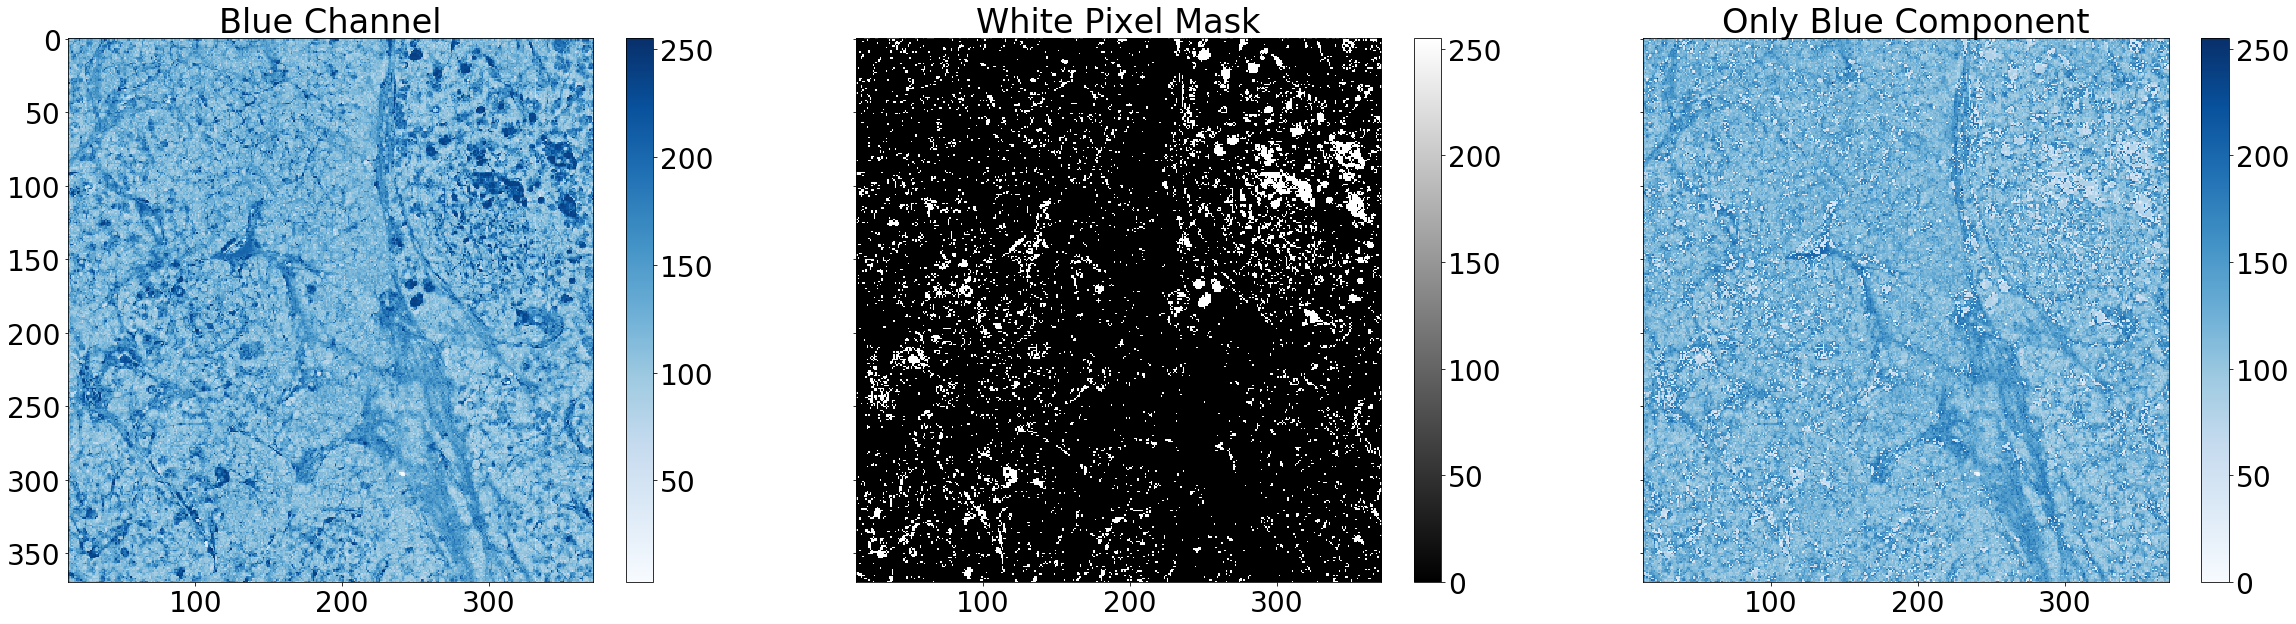

In [4]:
import numpy as np
plt.rcParams.update({'font.size': 28})

whtie_mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, whtie_mask = cv2.threshold(whtie_mask,175,255,cv2.THRESH_BINARY)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(40, 10))

ax1.set_title('Blue Channel')
fig1 = ax1.imshow(img_b,  cmap='Blues')
plt.colorbar(fig1,ax=ax1)

ax2.set_title('White Pixel Mask')
fig2 = ax2.imshow(whtie_mask,  cmap='gray')
plt.colorbar(fig2,ax=ax2)

new_image = np.asarray(img_b) -  (100*np.asarray(whtie_mask))
#img_b = new_image

ax3.set_title('Only Blue Component')
fig3 = ax3.imshow(new_image, cmap='Blues')
plt.colorbar(fig3,ax=ax3)

plt.show()


### Part Four: Thresholding
We can see in each of the above images, that a lot is colored blue, red, and green; however, we are only interested in the blue channels most saturated values (the blue regions in the original image. So we are going to employ a technique called 'thresholding.' Essentially what this does is takes the image, and any value less than 'n' will get set to zero. 

There is a good amount going on here, but I have done this in order to show you all the different thresholding tools that are available to you. 


#### Non-Adaptive Threshold Options:
------------------------------
* BINARY - Everything that is above the value 127 is set to 255, everything else is set to 0
* BINARY_INV - Everything that is above the value 127 is set to 0, everything else is set to 255
* TRUNC - Everything above 127 is set to 255, everything else is left as is
* TOZERO - Send everything less than 127 to 0, and leave the rest of the values
* TOZERO_INV - Send everything greater than 127 to 0 and leave the rest of the values

-------------------------------

At first, some of these may seem like good options for us to use (and others very poor), but before selecting one, we should attempt some adaptive thresholding

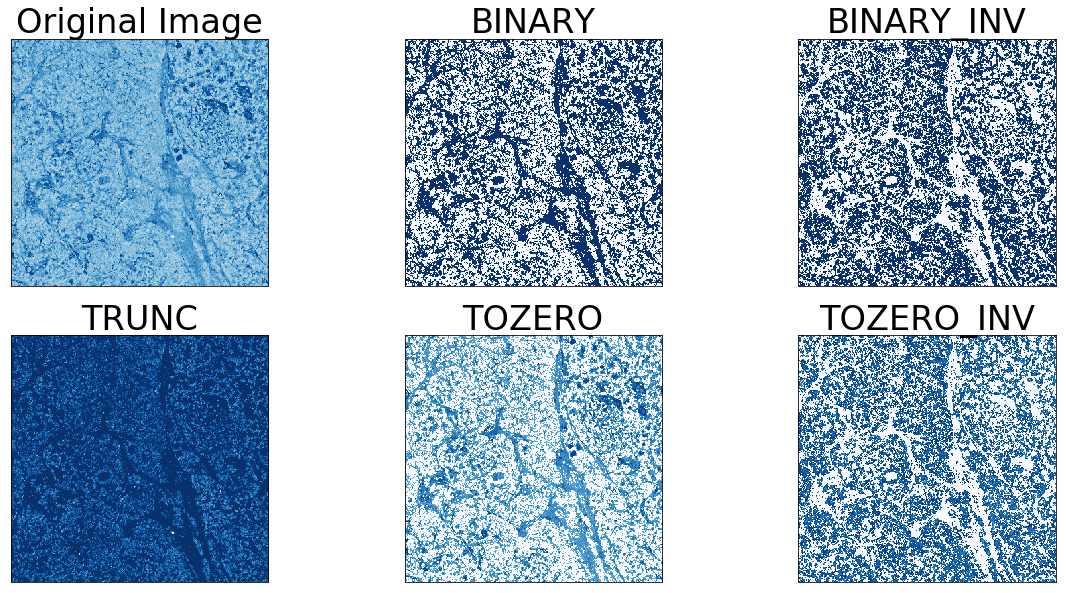

In [5]:
plt.figure(figsize=(20,10))

threshold_value = 127

ret,thresh1 = cv2.threshold(img_b,threshold_value,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img_b,threshold_value,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img_b,threshold_value,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img_b,threshold_value,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img_b,threshold_value,255,cv2.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img_b, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in xrange(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'Blues')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### Part Five: Adaptive Thresholding

When it comes to adaptive thresholding, there is only *really* one name to remember: OTSU. In my experience, OTSU thresholding is almost always the most promising kind of threhsolding, and because it is a bit complex, its workings fall out of the scope of this tutorial. However, what I would recomment trying is selecting your favorite thresholding techinque from above, and combining it with OTSU thresholding. I have done that below with the addition of an eample of how to do Gaussian adaptive thresholding and mean adaptive thresholding. 

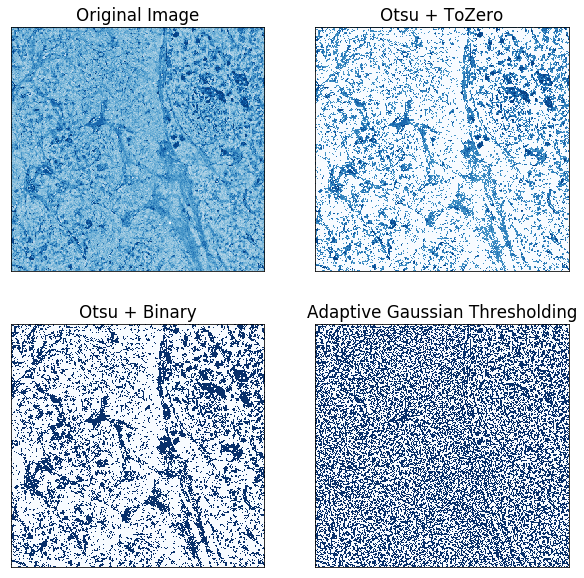

In [6]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 14})


img_b = cv2.convertScaleAbs(img_b)
ret,otsu_zero = cv2.threshold(img_b,threshold_value,255,cv2.THRESH_TOZERO+cv2.THRESH_OTSU)
ret,otsu_bin = cv2.threshold(img_b,threshold_value,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
th2 = cv2.adaptiveThreshold(img_b,127,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img_b,127,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
titles = ['Original Image', 'Otsu + ToZero',
            'Otsu + Binary', 'Adaptive Gaussian Thresholding']
images = [img_b, otsu_zero, otsu_bin, th3]
for i in xrange(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'Blues')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### Part Six: Picking and Finalizing Thresholded Image

Now that we have looked at our thresholding options lets talk about picking one and cleaning it up as much as possible.

So, I am going to pick the Otsu + Binary Image. The fact that the image is binary is nice becuase it will allow us to uniformly operate over the image as one mask -- perhapse I will come back and change this after I have finished writing the tutorial.

#### Cleaning (Part One)
---------------------

Remember that time we made a white pixel mask? Well, we did that so that we could do OTSU adaptive thresholding on an image and only get the most blue-saturated pixels before we subtract. If we substract first, we change the distribution of blue-saturated pixels which will negatively impact the performance of the OTSU algorithm. 


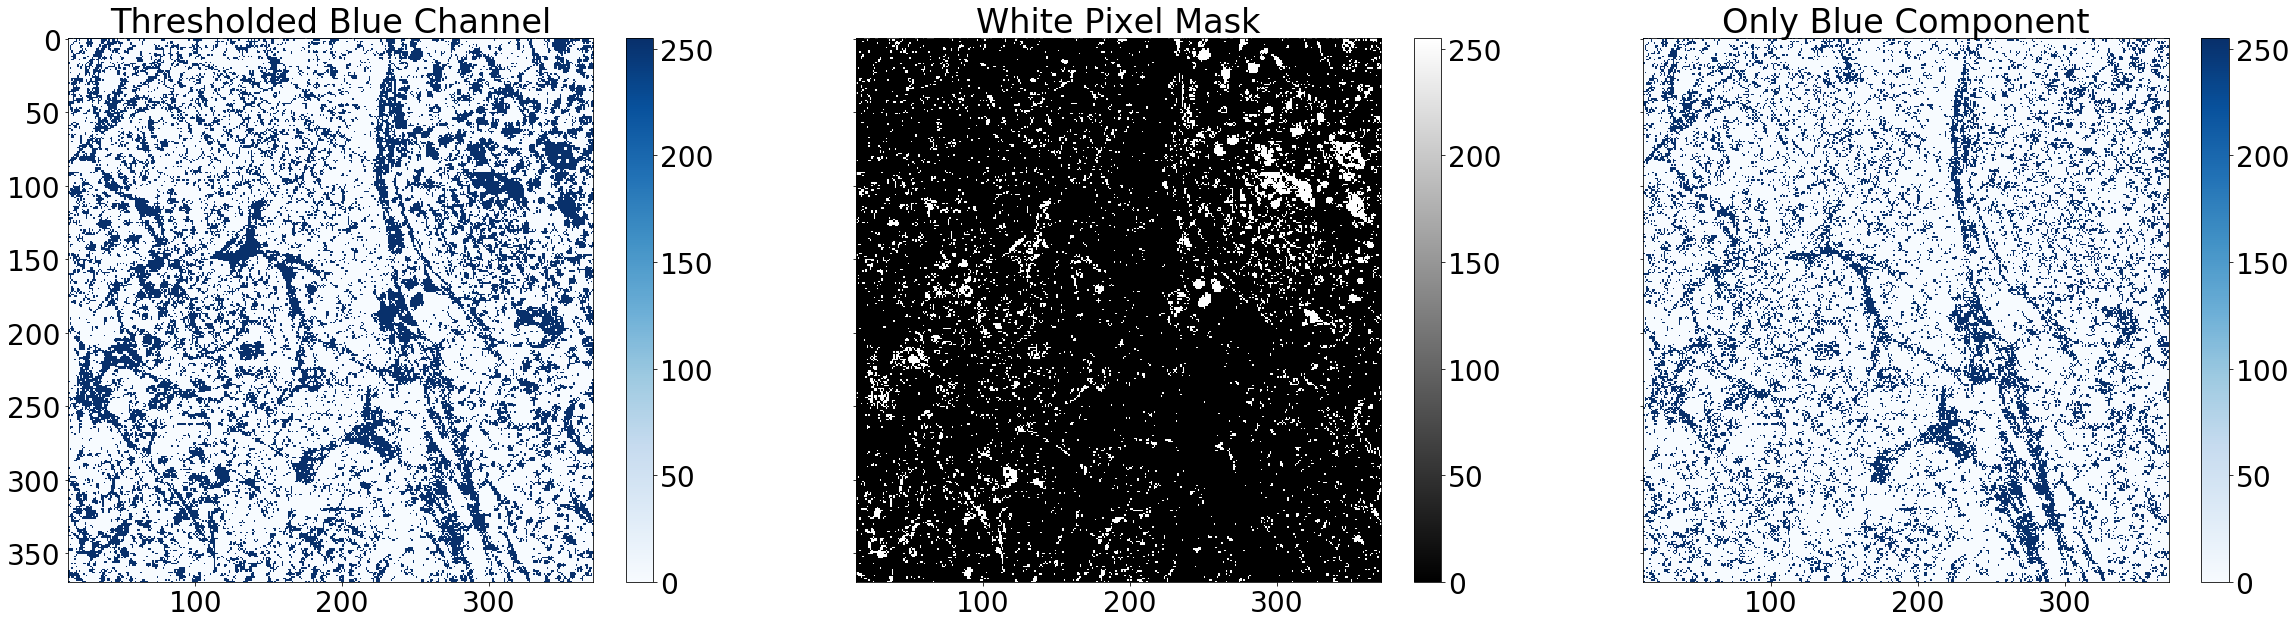

In [7]:
plt.rcParams.update({'font.size': 28})
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(40, 10))

im_chosen = otsu_bin

ax1.set_title('Thresholded Blue Channel')
fig1 = ax1.imshow(im_chosen,  cmap='Blues')
plt.colorbar(fig1,ax=ax1)

ax2.set_title('White Pixel Mask')
fig2 = ax2.imshow(whtie_mask,  cmap='gray')
plt.colorbar(fig2,ax=ax2)

final_im = np.asarray(im_chosen) -  (np.asarray(whtie_mask))

ax3.set_title('Only Blue Component')
fig3 = ax3.imshow(final_im, cmap='Blues')
plt.colorbar(fig3,ax=ax3)

plt.show()


### Part Seven: Cleaning the Image

Even after we have subtracted the white component of the image, there is still a decent amount of noise in the image. What exactly do I mean by noise? Well, it sort of looks like someone has sprinkled salt and pepper all over our image. 

To get rid of this noise, we are going to apply a fast denoising operations. For now, this is a bit hand wavy. I will come back are re-document all of this.

Another invaluable tool in image analysis, and manual denoising are morphological operations. These morphological operations are perfectly surmized here: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html


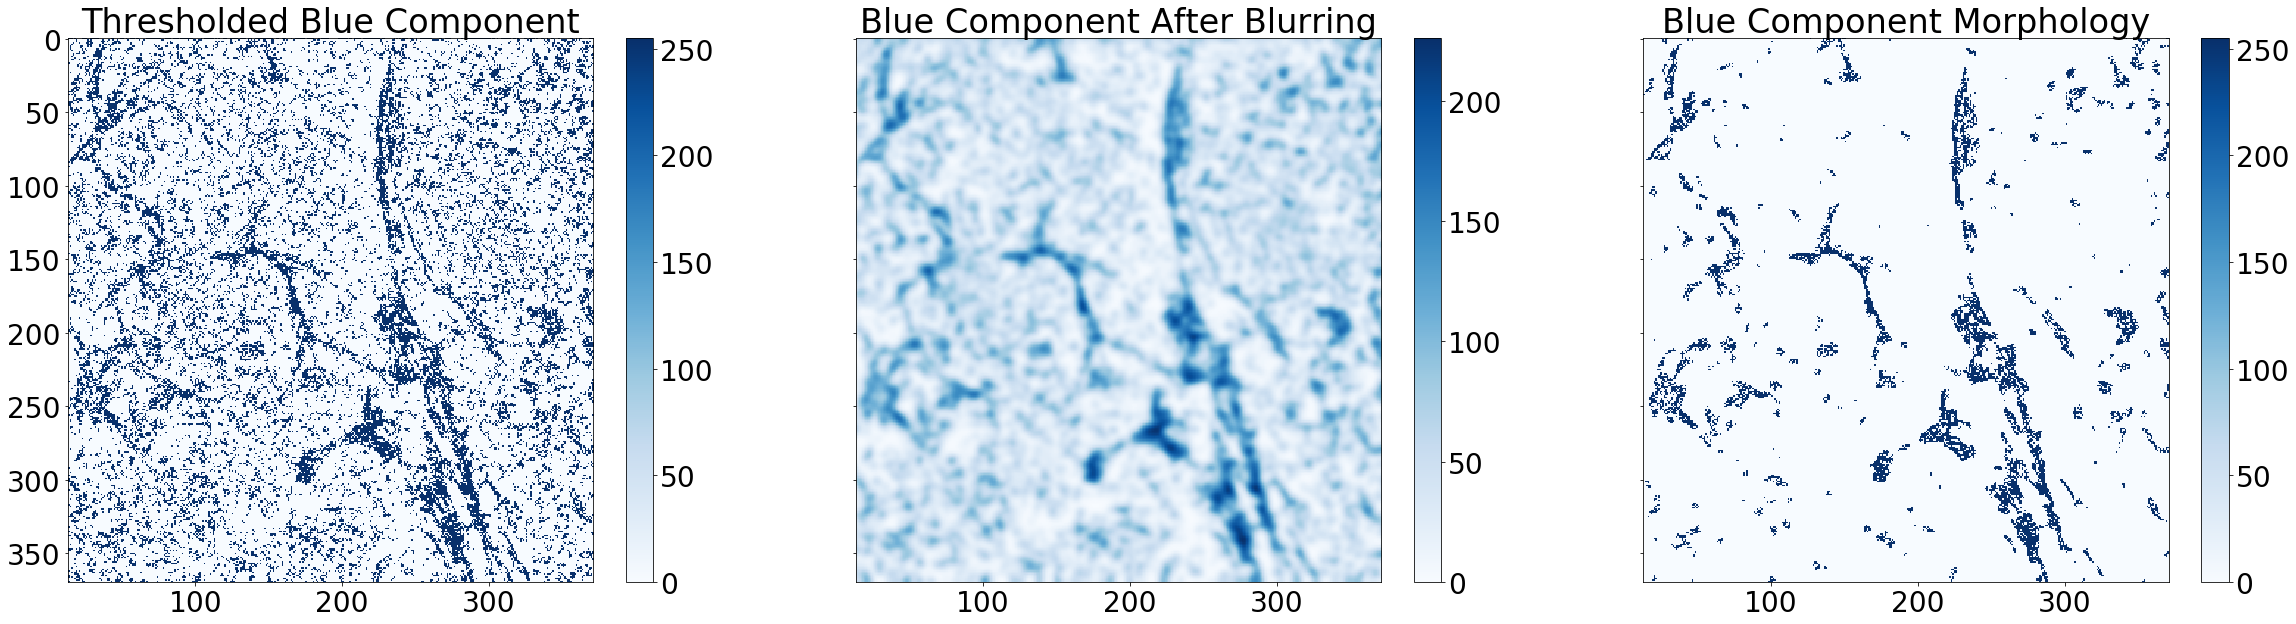

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(40, 10))

ax1.set_title('Thresholded Blue Component')
fig1 = ax1.imshow(final_im,  cmap='Blues')
plt.colorbar(fig1,ax=ax1)

blur = cv2.GaussianBlur(final_im,(15,15),0)

ax2.set_title('Blue Component After Blurring')
fig2 = ax2.imshow(blur,  cmap='Blues')
plt.colorbar(fig2,ax=ax2)

denoise = cv2.cvtColor(final_im, cv2.COLOR_GRAY2BGR)
denoise = cv2.fastNlMeansDenoisingColored(denoise,None,60,60,7,21)
denoise = cv2.cvtColor(denoise, cv2.COLOR_BGR2GRAY)
r, denoise = cv2.threshold(denoise,200,255,cv2.THRESH_BINARY)


ax3.set_title('Blue Component Morphology')
fig3 = ax3.imshow(denoise, cmap='Blues')
plt.colorbar(fig3,ax=ax3)

plt.show()

### Part Eight: Stain Localization

At this point, we have distilled exactly the regions of interests into a mask where zeros indicate regions where no staining has occured and ones indicate staining.

But, apart from just looking at the area that is stained, what if I want to look at individual, disjoint stained areas? Well, before we can describe such areas, we need to locate them. 

In this section, we will quickly go over how to localize our regions of interest using OpenCV's contour detection

In [9]:
img = cv2.imread('test.png', cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

im2, contours, hierarchy = cv2.findContours(denoise, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
inked = cv2.drawContours(img, contours, -1, (0,0,255), 3)


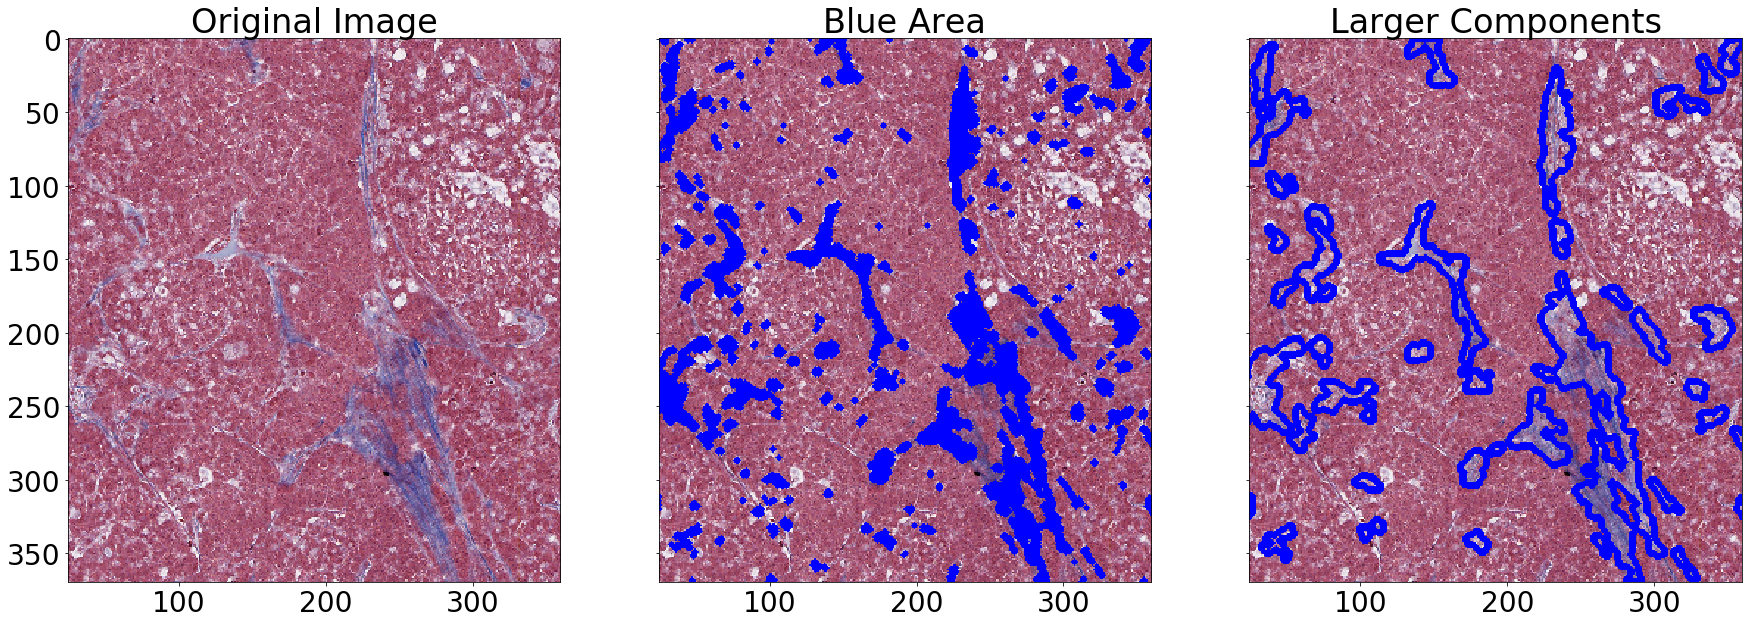

In [12]:
plt.rcParams.update({'font.size': 28})

kernel = np.ones((2,2),np.uint8)
inflated = cv2.dilate(denoise,kernel,iterations = 3)

img = cv2.imread('test.png', cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

im2, contours, hierarchy = cv2.findContours(inflated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
real_conts = []
for i in contours:
    if(100 < cv2.contourArea(i)):
        real_conts.append(i)
        
circed = cv2.drawContours(img, real_conts, -1, (0,0,255), 3)

img = cv2.imread('test.png', cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(30, 10))

ax1.set_title('Original Image')
fig1 = ax1.imshow(img)

ax2.set_title('Blue Area')
fig2 = ax2.imshow(inked)


ax3.set_title('Larger Components')
fig3 = ax3.imshow(circed)

plt.show()


### Part Nine: Statistical Summaries

Now that we have localized each of the major areas, lets go through and describe them statistically and see if we can come up with some cool plots to try to understand the different morphological features that are observed in the stain.

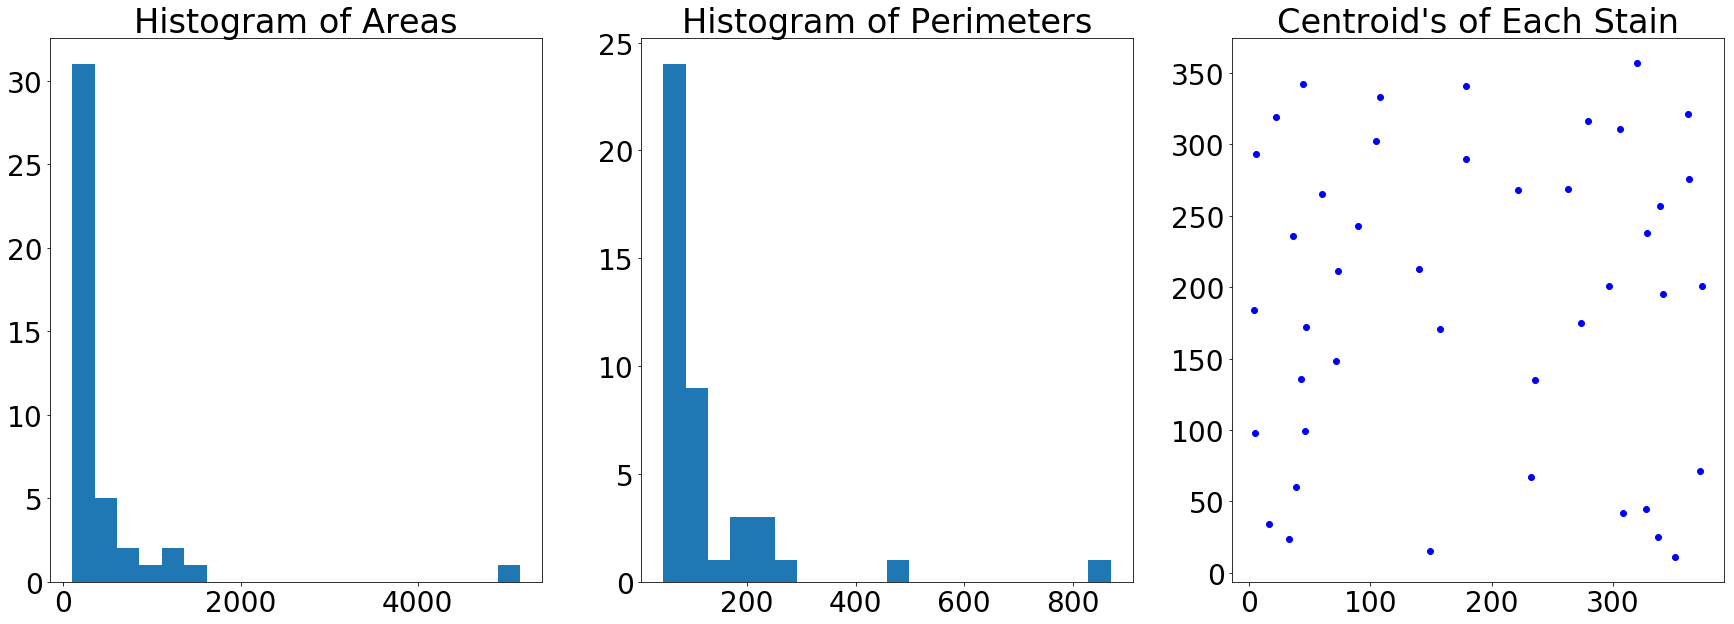

In [33]:
plt.rcParams.update({'font.size': 28})

areas = []
perims = []
cent_x = []
cent_y = []

for i in real_conts:
    areas.append(cv2.contourArea(i))
    perims.append(cv2.arcLength(i,True))
    M = cv2.moments(i)
    cent_x.append(int(M['m10']/M['m00']))
    cent_y.append(int(M['m01']/M['m00']))
 

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(30, 10))

ax1.set_title('Histogram of Areas')
fig1 = ax1.hist(areas, bins=20)

ax2.set_title('Histogram of Perimeters')
fig2 = ax2.hist(perims, bins=20)


ax3.set_title("Centroid's of Each Stain")
fig3 = ax3.scatter(cent_x, cent_y, marker='o', c='b')

plt.show()

